# Classification using multiple RNN models with bagging method

The goal for this notebook is to predict how long will it take to do a recipe based on the [Recipe NLG Dataset](https://recipenlg.cs.put.poznan.pl/)

## ⬇️ Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
from torchmetrics import MeanAbsoluteError, R2Score, MeanSquaredError
from gensim.models import Word2Vec
import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
WORD2VEC = False# YOU MUST SET THE WORD2VEC TO FALSE OR TRUE DEPENDING ON YOUR WISHES

SyntaxError: invalid syntax (4142905011.py, line 1)

## 🛠️ Preprocessing
### Downloading the dataset

If not already done use this [notebook](../../preprocessing/preprocessing.ipynb) to download the dataset in your local directory.

In [3]:
data = pd.read_csv('../../data/processed/preprocessed_recipe.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/processed/preprocessed_recipe.csv'

In [3]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216685 entries, 0 to 216684
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   index                     216685 non-null  int64  
 1   id                        216685 non-null  int64  
 2   name                      216635 non-null  object 
 3   minutes                   216685 non-null  int64  
 4   n_steps                   216685 non-null  int64  
 5   description               216685 non-null  object 
 6   n_ingredients             216685 non-null  int64  
 7   steps_string_standardize  216685 non-null  object 
 8   ingredients_text          216685 non-null  object 
 9   tags_text                 216685 non-null  object 
 10  calories                  216685 non-null  float64
 11  total_fat                 216685 non-null  float64
 12  sugar                     216685 non-null  float64
 13  sodium                    216685 non-null  f

In [4]:
data.head()

,index,id,name,minutes,n_steps,description,n_ingredients,steps_string_standardize,ingredients_text,tags_text,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,0,137739,arriba baked squash mexican,55,11,autumn is my favorite time of year to cook! th...,7,make a choic and proceed with recip depend on ...,"['winter squash', 'mexican seasoning', 'mixed ...","['60-minutes-or-less', 'time-to-make', 'course...",51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,1,31490,breakfast pizza,30,9,this recipe calls for the crust to be prebaked...,6,preheat oven to 103.33 celsius °c press dough ...,"['prepared pizza crust', 'sausage patty', 'egg...","['30-minutes-or-less', 'time-to-make', 'course...",173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,2,112140,chili,130,6,this modified version of 'mom's' chili was a h...,13,brown ground beef in larg pot add chop onion t...,"['ground beef', 'yellow onions', 'diced tomato...","['time-to-make', 'course', 'preparation', 'mai...",269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,3,59389,alouette potato,45,11,"this is a super easy, great tasting, make ahea...",11,place potato in a larg pot of lightli salt wat...,"['spreadable cheese with garlic and herbs', 'n...","['60-minutes-or-less', 'time-to-make', 'course...",368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,4,44061,amish tomato ketchup canning,190,5,my dh's amish mother raised him on this recipe...,8,"mix all ingredients& boil for 2 30.0 minute , ...","['tomato juice', 'apple cider vinegar', 'sugar...","['weeknight', 'time-to-make', 'course', 'main-...",352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [ ]:
def preprocess_text(text):
    """Tokenize text and remove stopwords"""
    if not isinstance(text, str):
        return []
    
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    return tokens

def build_word2vec_model(tokenized_texts, vector_size=100, window=5, min_count=1, workers=max(1, int(os.cpu_count() * 0.70))):
    """Train a Word2Vec model on the tokenized texts"""
    model = Word2Vec(sentences=tokenized_texts, 
                    vector_size=vector_size, 
                    window=window, 
                    min_count=min_count, 
                    workers=workers)
    model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=10)
    return model

def get_document_vector(tokenized_doc, word2vec_model, vector_size):
    """Create a document vector by averaging word vectors"""
    doc_vector = np.zeros(vector_size)
    count = 0
    
    for word in tokenized_doc:
        if word in word2vec_model.wv:
            doc_vector += word2vec_model.wv[word]
            count += 1
    
    if count > 0:
        doc_vector /= count
    
    return doc_vector

' seems to have no effect\nnlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger", "lemmatizer"])\ntexts = data["steps_string_standardize"].astype(str).tolist()\nnum_cpus = os.cpu_count()\nn_process = max(1, int(num_cpus * 0.7)) if num_cpus else 1\ndocs = list(nlp.pipe(texts, batch_size=50, n_process=n_process))\ndata["steps_tokens"] = [[token.text for token in doc] for doc in docs]\n'

In [ ]:
if WORD2VEC:
    print("Building Word2Vec features matrices...")

    # Tokenize texts
    steps_tokenized = data["steps_string_standardize"].apply(preprocess_text).tolist()
    ingredients_tokenized = data["ingredients_text"].apply(preprocess_text).tolist()
    tags_tokenized = data["tags_text"].apply(preprocess_text).tolist()
    
    # Build Word2Vec models
    steps_w2v = build_word2vec_model(steps_tokenized, vector_size=400)
    ingredients_w2v = build_word2vec_model(ingredients_tokenized, vector_size=150)
    tags_w2v = build_word2vec_model(tags_tokenized, vector_size=100)
    
    # Create document vectors
    steps_features = np.array([get_document_vector(doc, steps_w2v, 400) for doc in steps_tokenized])
    ingredients_features = np.array([get_document_vector(doc, ingredients_w2v, 150) for doc in ingredients_tokenized])
    tags_features = np.array([get_document_vector(doc, tags_w2v, 100) for doc in tags_tokenized])
    
    # Numerical features
    numerical_features = data[['n_steps', 'n_ingredients', 'calories', 'total_fat', 'sugar', 'sodium', 'saturated_fat', 'carbohydrates']].values
    
    feature_matrices = [steps_features, ingredients_features, tags_features, numerical_features]
    print("Finish building Word2Vec features matrices...")
else:
    print("Building TF-IDF features matrices...")
    steps_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
    steps_features = steps_vectorizer.fit_transform(data["steps_string_standardize"])

    ingredients_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
    ingredients_features = ingredients_vectorizer.fit_transform(data["ingredients_text"])

    tags_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
    tags_features = tags_vectorizer.fit_transform(data["tags_text"])
    print("Finish building TF-IDF features matrices...")

In [7]:
numerical_features = data[['n_steps', 'n_ingredients', 'calories', 'total_fat', 'sugar', 'sodium', 'saturated_fat', 'carbohydrates']].values

feature_matrices = [steps_features.toarray(), ingredients_features.toarray(),
                    tags_features.toarray(),
                   numerical_features]

In [8]:
X = np.hstack(feature_matrices)
y = data["minutes"].values

In [9]:
X_train, X_test, y_train, y_test, X_train_indices, X_test_indices = train_test_split(
    X, y, data.index, test_size=0.2, random_state=42
)

We will be using torch to build our model, but first we need to tranform our data into a format that can be used by torch (PyTorch Tensor).

In [10]:
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)
del X_train
del X_test
del y_train
del y_test
del X_train_indices
del X_test_indices
del data

## Training our model and Defining Metrics


- MAE :
    - Represents how much is it off on average
    - Ex : You make predictions that are off by 15 minutes on average

- R^2 :
    - Ranges from negative to 1
    - The closer it is to 1 the better it is
    - Under 0 it performs worse then random

#### Baseline model with a single Linear layer

In [ ]:
class LinearRecipeTimePredicator(torch.nn.Module):
    def __init__(self, input_size):
        super(LinearRecipeTimePredicator, self).__init__()
        self.model = torch.nn.Linear(input_size, 1)
    def forward(self, x):
        return self.model(x)


#### RNN model with LSTM architecture.
- LSTM (Long Short Term Memory) is a type of RNN that is capable of learning long-term dependencies.
- Good results for this one but a really long training time, moreover it is necessary to create an artificial sequence of 32 features to train it.

In [12]:

class RNNRecipeTimePredictorLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(RNNRecipeTimePredictorLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # reshape features into sequence format
        # we have artificially created a data sequence (we have taken 32 features from the ~11000 features)
        self.seq_length = 32
        self.input_per_step = input_size // self.seq_length + (1 if input_size % self.seq_length != 0 else 0)
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(
            input_size=self.input_per_step,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # no activation function 
        self.fc = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # pad input if sequence length is less than 32
        padded_length = self.seq_length * self.input_per_step
        if x.size(1) < padded_length:
            padding = torch.zeros(batch_size, padded_length - x.size(1), device=x.device)
            x = torch.cat([x, padding], dim=1)
        
        # must reshape 
        x = x.view(batch_size, self.seq_length, self.input_per_step)
        
        # initialize hidden layers
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        output, _ = self.lstm(x, (h0, c0))
        
        output = output[:, -1, :]
        
        return self.fc(output)

In [13]:
def load_checkpoint(checkpoint_path, model, optimizer=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


def save_checkpoint(model, optimizer, epoch, loss, filename="../../../data/weights/checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}")

In [14]:
class GRURecipeTimePredictor(torch.nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(GRURecipeTimePredictor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.seq_length = 32
        self.input_per_step = input_size // self.seq_length + (1 if input_size % self.seq_length != 0 else 0)
        
        self.gru = torch.nn.GRU(
            input_size=self.input_per_step,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        padded_length = self.seq_length * self.input_per_step
        if x.size(1) < padded_length:
            padding = torch.zeros(batch_size, padded_length - x.size(1), device=x.device)
            x = torch.cat([x, padding], dim=1)
        
        x = x.view(batch_size, self.seq_length, self.input_per_step)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        output, _ = self.gru(x, h0)
        output = output[:, -1, :]
        
        return self.fc(output)

In [ ]:
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
model, _, _, _ = load_checkpoint("../../../data/weights/checkpoint.pth", model=GRURecipeTimePredictor(input_size=X_train_tensor.shape[1]))

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for batch_X, batch_y in test_loader:
        y_pred_batch = model(batch_X)
        predictions.append(y_pred_batch.numpy())
        actuals.append(batch_y.numpy())
    
    y_pred = np.vstack(predictions).flatten()
    mae = MeanAbsoluteError()
    r2_score = R2Score()
    mse = MeanSquaredError()
    
    mae.update(torch.FloatTensor(y_pred), y_test_tensor)
    r2_score.update(torch.FloatTensor(y_pred), y_test_tensor)
    mse.update(torch.FloatTensor(y_pred), y_test_tensor)
    mean_squared_error= mse.compute()
    root_mean_squared_error = np.sqrt(mean_squared_error)
    print(f"Root Mean Squared Error: {root_mean_squared_error}")
    print(f"Mean Absolute Error: {mae.compute()}")
    print(f"Mean Squared Error: {mean_squared_error}")
    print(f"R2 Score: {r2_score.compute()}")

Root Mean Squared Error: 18.37567138671875
Mean Absolute Error: 9.787269592285156
Mean Squared Error: 337.6653137207031
R2 Score: 0.8406842947006226
Mean Absolute Percentage Error (MAPE): 26.14%


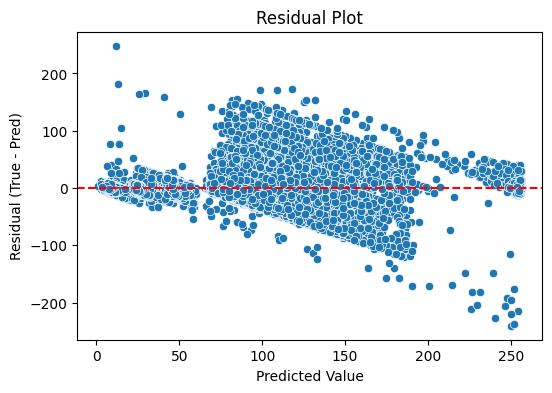

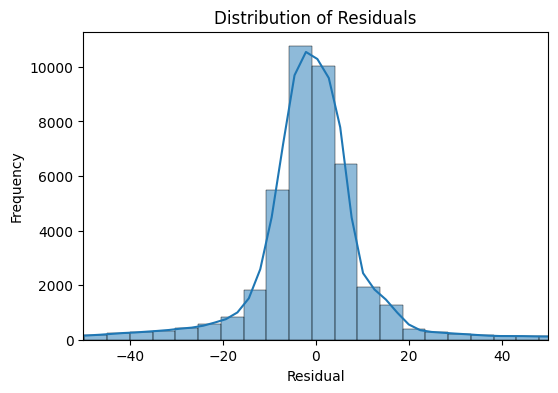

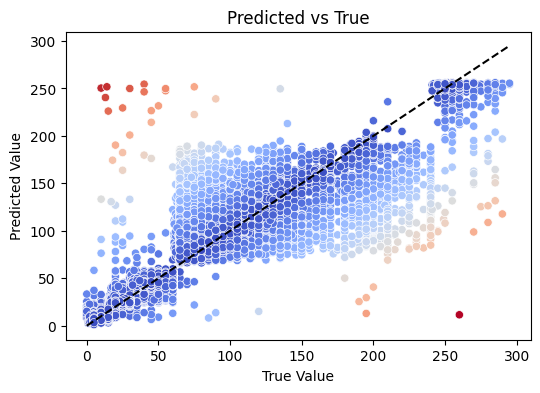

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_test_np = y_test_tensor.numpy() if hasattr(y_test_tensor, "numpy") else np.array(y_test_tensor)
y_pred_np = y_pred if isinstance(y_pred, np.ndarray) else np.array(y_pred)

errors = y_test_np - y_pred_np
abs_errors = np.abs(errors)

# Residual Plot with smaller y-axis range
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=errors)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Value")
plt.ylabel("Residual (True - Pred)")
#plt.ylim(-100, 100)  # Set y-axis range for residuals
plt.show()

# Histogram of Residuals
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, bins=100)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim(-50, 50)  # Set x-axis range for residuals
plt.show()

# Predicted vs True Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test_tensor, y=y_pred, hue=abs_errors, palette='coolwarm', legend=False)
plt.plot([y_test_tensor.min(), y_test_tensor.max()], [y_test_tensor.min(), y_test_tensor.max()], 'k--')  # Diagonal
plt.title("Predicted vs True")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

In [ ]:
input_size = X_train_tensor.shape[1]
model = GRURecipeTimePredictor(input_size)
#model = LinearRecipeTimePredicator(input_size)
#model = RNNRecipeTimePredictorLSTM(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Load checkpoint once before starting training
try:
    model, optimizer, start_epoch, last_loss = load_checkpoint("../../../data/weights/checkpoint.pth", model, optimizer)
    print(f"Resuming training from epoch {start_epoch+1} with previous loss: {last_loss:.4f}")
except FileNotFoundError:
    start_epoch = -1
    last_loss = float('inf')
    print("No checkpoint found. Starting training from scratch.")
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"


print(f"Using {device} device")
epochs = 50
for epoch in range(start_epoch + 1, epochs):
    model, optimizer, start_epoch, last_loss = load_checkpoint("../../../data/weights/checkpoint.pth", model, optimizer)
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        batch_y = batch_y.view(-1, 1)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    save_checkpoint(model, optimizer, epoch, avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for batch_X, batch_y in test_loader:
        y_pred_batch = model(batch_X)
        predictions.append(y_pred_batch.numpy())
        actuals.append(batch_y.numpy())
    
    y_pred = np.vstack(predictions).flatten()
    mean_absolute_error = MeanAbsoluteError()
    r2_score = R2Score()
    
    mean_absolute_error.update(torch.FloatTensor(y_pred), y_test_tensor)
    r2_score.update(torch.FloatTensor(y_pred), y_test_tensor)
    mean_squared_error= mean_absolute_error.compute()
    print(f"Mean Absolute Error: {mean_squared_error}")
    print(f"R2 Score: {r2_score.compute()}")
    

Using cpu device


KeyboardInterrupt: 

# Small tests

In [ ]:
y_pred_lr = pd.DataFrame(y_pred, columns=["predicted_minutes"])

In [ ]:
original_row = data.loc[X_test_indices[33]]
display(original_row)

print("y_test[33]:", y_test[33])
print("y_pred_lr[33]:", y_pred_lr[33])

id                                                                     322833
name                                            cucumber cilantro pasta salad
minutes                                                                    30
n_steps                                                                     4
description                 so cool and refreshing. if you like spicy, you...
n_ingredients                                                               9
steps_string_standardize    cook pasta , drain combin lime juic , cilantro...
ingredients_text            ['cucumber', 'roma tomato', 'red onion', 'lime...
tags_text                   ['30-minutes-or-less', 'time-to-make', 'course...
calories                                                                 34.8
total_fat                                                                 0.0
sugar                                                                    18.0
sodium                                                          

y_test[33]: 30
y_pred_lr[33]: 26.619497648857614


In [ ]:
data.head()

,id,name,minutes,n_steps,description,n_ingredients,steps_string_standardize,ingredients_text,tags_text,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,137739,arriba baked squash mexican,55,11,autumn is my favorite time of year to cook! th...,7,make a choic and proceed with recip depend on ...,"['winter squash', 'mexican seasoning', 'mixed ...","['60-minutes-or-less', 'time-to-make', 'course...",51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,31490,breakfast pizza,30,9,this recipe calls for the crust to be prebaked...,6,preheat oven to 103.33 celsius °c press dough ...,"['prepared pizza crust', 'sausage patty', 'egg...","['30-minutes-or-less', 'time-to-make', 'course...",173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,112140,chili,130,6,this modified version of 'mom's' chili was a h...,13,brown ground beef in larg pot add chop onion t...,"['ground beef', 'yellow onions', 'diced tomato...","['time-to-make', 'course', 'preparation', 'mai...",269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,59389,alouette potato,45,11,"this is a super easy, great tasting, make ahea...",11,place potato in a larg pot of lightli salt wat...,"['spreadable cheese with garlic and herbs', 'n...","['60-minutes-or-less', 'time-to-make', 'course...",368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,44061,amish tomato ketchup canning,190,5,my dh's amish mother raised him on this recipe...,8,"mix all ingredients& boil for 2 30.0 minute , ...","['tomato juice', 'apple cider vinegar', 'sugar...","['weeknight', 'time-to-make', 'course', 'main-...",352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [ ]:
class BaggingGRUEnsemble:
    def __init__(self, input_size, n_models=8, sample_ratio=0.6, hidden_size=128, num_layers=2, dropout=0.2):
        """
        Initialize a bagging ensemble of GRU models
        
        Args:
            input_size: Feature dimensionality
            n_models: Number of models in the ensemble
            sample_ratio: Portion of training data to use for each model (0.6 = 60%)
            hidden_size, num_layers, dropout: Parameters for GRU models
        """
        self.n_models = n_models
        self.sample_ratio = sample_ratio
        self.models = [
            GRURecipeTimePredictor(input_size, hidden_size, num_layers, dropout) 
            for _ in range(n_models)
        ]
        self.optimizers = [
            torch.optim.AdamW(model.parameters(), lr=0.001) 
            for model in self.models
        ]
        
    def train(self, train_tensor_x, train_tensor_y, batch_size=64, epochs=10, 
              checkpoint_path="../../../data/weights/bagging_gru"):
        """Train all models in the ensemble on different bootstrap samples"""
        import os
        os.makedirs(checkpoint_path, exist_ok=True)
        
        criterion = torch.nn.MSELoss()
        dataset_size = len(train_tensor_x)
        sample_size = int(dataset_size * self.sample_ratio)
        
        for model_idx, (model, optimizer) in enumerate(zip(self.models, self.optimizers)):
            print(f"\nTraining model {model_idx+1}/{self.n_models}")
            
            for epoch in range(epochs):
                # Create a bootstrap sample for this epoch
                indices = torch.randperm(dataset_size)[:sample_size]
                x_sample = train_tensor_x[indices]
                y_sample = train_tensor_y[indices]
                
                # Create data loader for this sample
                sample_dataset = torch.utils.data.TensorDataset(x_sample, y_sample)
                sample_loader = torch.utils.data.DataLoader(
                    sample_dataset, batch_size=batch_size, shuffle=True
                )
                
                # Train the model on this sample
                model.train()
                total_loss = 0
                
                for batch_x, batch_y in sample_loader:
                    outputs = model(batch_x)
                    batch_y = batch_y.view(-1, 1)
                    loss = criterion(outputs, batch_y)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                
                avg_loss = total_loss / len(sample_loader)
                print(f"  Model {model_idx+1}, Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
                
                # Save checkpoint after each epoch
                model_path = f"{checkpoint_path}/model_{model_idx}_epoch_{epoch}.pth"
                save_checkpoint(model, optimizer, epoch, avg_loss, filename=model_path)
    
    def predict(self, x_tensor):
        """Get predictions from all models and return their mean"""
        self.set_eval_mode()
        
        with torch.no_grad():
            # Get predictions from each model
            all_predictions = []
            
            for model in self.models:
                pred = model(x_tensor)
                all_predictions.append(pred)
                
            # Stack and compute mean across models
            stacked_preds = torch.stack(all_predictions)
            ensemble_pred = torch.mean(stacked_preds, dim=0)
            
        return ensemble_pred
    
    def set_eval_mode(self):
        """Set all models to evaluation mode"""
        for model in self.models:
            model.eval()
            
    def load_models(self, checkpoint_path="../../../data/weights/bagging_gru", epoch=9):
        """Load all models from checkpoints"""
        for model_idx, model in enumerate(self.models):
            optimizer = self.optimizers[model_idx]
            model_path = f"{checkpoint_path}/model_{model_idx}_epoch_{epoch}.pth"
            try:
                model, optimizer, _, _ = load_checkpoint(model_path, model, optimizer)
                self.optimizers[model_idx] = optimizer
                print(f"Loaded model {model_idx} from {model_path}")
            except FileNotFoundError:
                print(f"Warning: Could not find checkpoint for model {model_idx}")

In [ ]:
# Create and train the ensemble
input_size = X_train_tensor.shape[1]
ensemble = BaggingGRUEnsemble(input_size, n_models=8, sample_ratio=0.6)
ensemble.train(X_train_tensor, y_train_tensor, batch_size=64, epochs=10)

In [ ]:
# Evaluate the ensemble
ensemble.set_eval_mode()
with torch.no_grad():
    # Get predictions on test set
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size
    )
    predictions = []
    actuals = []
    
    for batch_X, batch_y in test_loader:
        y_pred_batch = ensemble.predict(batch_X)
        predictions.append(y_pred_batch.numpy())
        actuals.append(batch_y.numpy())
    
    y_pred = np.vstack(predictions).flatten()
    
    # Calculate metrics
    mae = MeanAbsoluteError()
    r2_score = R2Score()
    mse = MeanSquaredError()
    
    mae.update(torch.FloatTensor(y_pred), y_test_tensor)
    r2_score.update(torch.FloatTensor(y_pred), y_test_tensor)
    mse.update(torch.FloatTensor(y_pred), y_test_tensor)
    
    mean_squared_error = mse.compute()
    root_mean_squared_error = np.sqrt(mean_squared_error)
    
    print(f"Root Mean Squared Error: {root_mean_squared_error}")
    print(f"Mean Absolute Error: {mae.compute()}")
    print(f"Mean Squared Error: {mean_squared_error}")
    print(f"R2 Score: {r2_score.compute()}")

In [ ]:
# Load trained models
new_data = [] # FIXME: Replace with actual new data for inference test
ensemble = BaggingGRUEnsemble(input_size, n_models=8, sample_ratio=0.6)
ensemble.load_models(epoch=9)  # Assuming we saved 10 epochs (0-9)

# Make prediction on a new sample
with torch.no_grad():
    new_data_tensor = torch.FloatTensor(new_data)
    prediction = ensemble.predict(new_data_tensor)
    print(f"Predicted cooking time: {prediction.item()} minutes")